Reference: https://github.com/melanieshi0120/NLP_Analysis_Amazon_Reviews/blob/master/Amazon_sport_product_review.ipynb<br>
data dource: http://jmcauley.ucsd.edu/data/amazon/

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import pickle
import re, string
import sys
import seaborn as sns
sns.set()
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

In [2]:
sport_and_outdoor = []
for line in open('Sports_and_Outdoors_5.json', 'r'):
    sport_and_outdoor.append(json.loads(line))

In [3]:
df = pd.DataFrame(sport_and_outdoor)
df.shape

(296337, 9)

In [4]:
# create a new column which combines review and summary
df['combined_text'] = df['reviewText'] + ' ' + df['summary']

In [5]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,combined_text
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014",This came in on time and I am veru happy with ...
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012",I had a factory Glock tool that I was using fo...
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012",If you don't have a 3/32 punch or would like t...
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012",This works no better than any 3/32 punch you w...
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013",I purchased this thinking maybe I need a speci...


### Data Cleaning

In [6]:
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      1402
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
combined_text        0
dtype: int64

There are some reviewrs' names are missing, er will remove reviewName columns

In [7]:
# check how many unique values in rating column
df['overall'].value_counts()

5.0    188208
4.0     64809
3.0     24071
2.0     10204
1.0      9045
Name: overall, dtype: int64

In [8]:
# create a target column based on product_rating, if rating <= 3 means bad: 0 if rating >= 4 good:1
df['target'] = [0 if x <= 3 else 1 for x in df['overall']]

In [9]:
# create a column for helpfulness numerator and helpfulness denominator
df['helpfulness_Numerator'] = [x[0] for x in df['helpful']]
df['helpfulness_Denominator'] = [x[1] for x in df['helpful']]

In [10]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,combined_text,target,helpfulness_Numerator,helpfulness_Denominator
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014",This came in on time and I am veru happy with ...,1,0,0
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012",I had a factory Glock tool that I was using fo...,1,1,1
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012",If you don't have a 3/32 punch or would like t...,1,2,2
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012",This works no better than any 3/32 punch you w...,1,0,0
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013",I purchased this thinking maybe I need a speci...,1,0,0


### Review Counts by Rating

Text(0.5, 1.0, 'Review Counts by Rating')

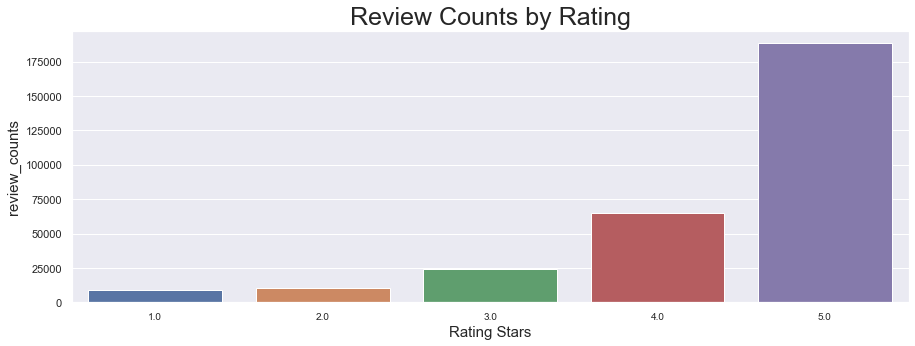

In [11]:
# plot review counts in different rating group
rating = pd.DataFrame(df['overall'].value_counts()).reset_index().sort_values(by='index', ascending=True)
plt.figure(figsize=(15,5))
sns.barplot(rating['index'], rating['overall'])
plt.xticks(fontsize=10)
plt.xlabel('Rating Stars', fontsize=15)
plt.ylabel('review_counts', fontsize=15)
plt.title('Review Counts by Rating', fontsize=25)

Text(0.5, 1.0, 'Review Counts by Bad.Good Reviews')

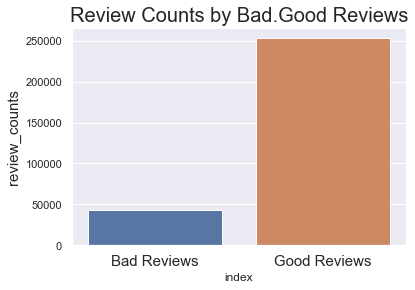

In [12]:
# plot review counts in bad review group and good review group
bad_good = pd.DataFrame(df['target'].value_counts()).reset_index().sort_values(by='index', ascending=False)
sns.barplot(bad_good['index'], bad_good['target'])
plt.xticks([0,1], ['Bad Reviews', 'Good Reviews'], fontsize=15)
plt.ylabel('review_counts', fontsize=15)
plt.title('Review Counts by Bad.Good Reviews', fontsize=20)

### Helpfulness

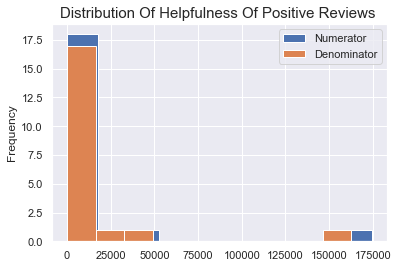

In [13]:
# Distribution of helpfulness_Numerator and helpfulness_Denominator in positive reviews
plt.title('distribution of helpfulness of positive Reviews '.title(), fontsize=15)
df[df['target']==1]['helpfulness_Numerator'].value_counts()[:20].plot(kind='hist', label='Numerator')
df[df['target']==1]['helpfulness_Denominator'].value_counts()[:20].plot(kind='hist', label='Denominator')
plt.legend()
plt.show()

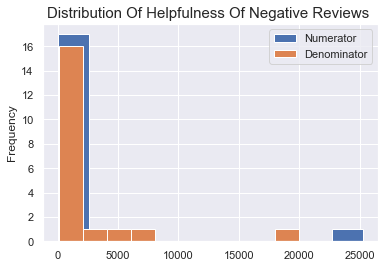

In [14]:
# distribution of helpfulness_Numerator and helpfulness_Denominator in negative reviews
plt.title('distribution of helpfulness of Negative Reviews '.title(), fontsize=15)
df[df['target']==0]['helpfulness_Numerator'].value_counts()[:20].plot(kind='hist', label='Numerator')
df[df['target']==0]['helpfulness_Denominator'].value_counts()[:20].plot(kind='hist', label='Denominator')
plt.legend()
plt.show()

### ReviewTime and target

In [15]:
import datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

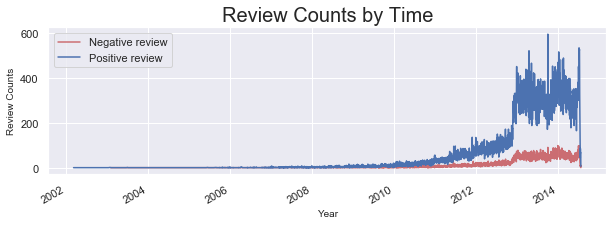

In [16]:
# plot how many products sold from 2003 to 2015
plt.figure(figsize=(10,3))
plt.title('Review Counts by Time', fontsize=20)
plt.ylabel('Review Counts', fontsize=10)
plt.xlabel('Year', fontsize=10)
df[df.target==0]['reviewTime'].value_counts().plot(label='Negative review', color='r', alpha=0.8)
df[df.target==1]['reviewTime'].value_counts().plot(label='Positive review', color='b')
plt.legend()
plt.show()

# In 2013, Amazon sells over 200 million products in the USA, which are categoried into 35 
# departments and almost 20 million in Sports & Outdoors

### Products

In [17]:
# Let's see in different rating level which products have highest rating - best seller
# plot the mean of rating for each product and got top 20 in rating:
pd.DataFrame(df.groupby('asin')['overall'].mean()).sort_values(by='overall', ascending=False).iloc[:5]

,overall
asin,
B00LFPS0CY,5.0
B003JJW610,5.0
B003EU8G22,5.0
B003EZQ53E,5.0
B003F4WKYW,5.0


In [18]:
# 1st :Hydracentials Sporty 25 oz Insulated Stainless Steel Water
# 2nd: Table Tennis Racket Cover 
# 3rd: Drymax Run Mini Crew Socks
# 4th: MSR Lightning Flotation Tail
# 5th: Tiberius Arms First Strike Paintballs (White, 100 Count)

In [19]:
# Wchi products are the best seller regardless their rating
best_seller = pd.DataFrame(df['asin'].value_counts()).sort_values(by='asin', ascending=False).iloc[:5]

In [20]:
best_seller

,asin
B001HBHNHE,1042
B001T7QJ9O,763
B000S5ODN2,647
B0010O748Q,513
B0000C50K3,427


In [21]:
# 1st Bike
# 2nd Impact Sport OD Green Electric Earmuff  
# 3rd 50 Feet, Black : Rothco 550lb. Type III Nylon Paracord for yoga 
# 4th Survival Bundle - LifeStraw Personal Water Filter AND Magnesium Fire Starter 
# 5th HOPPE'S 24011 BoreSnake Rifle Bore Cleaner, M-16.22-.223 Caliber, 5.56mm
#[' Pistol Magazine Loader','Electric Earmuff','Nylon Paracord for yoga','LifeStraw Water Filter','Rifle Bore Cleaner'])

### Bigrams before removing stop words

In [22]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [ ]:
common_words_good = get_top_n_bigram(df[df['target']==1]['combined_text'],30)
common_words_bad = get_top_n_bigram(df[df['target']==0]['combined_text'],30)

In [ ]:
plt.figure(figsize=(25,8))
# good reviews bigrams
plt.subplot(1,2,1)
x_good = [x[0] for x in common_words_good]
y_good = [x[1] for x in common_words_good]
sns.barplot(x_good, y_good, color='g')
plt.xticks(rotation=90, fontsize=20)
plt.title('Top 20 Bigrams in Positive Reviews', fontsize=20)
for i in range(len(x_good)):
    plt.text(i-0.2, y_good[i]+100, '{}'.format(y_good[i]), size=15, rotation=45)
    
plt.subplot(1,2,2)
x_bad = [x[0] for x in common_words_bad]
y_bad = [x[1] for x in common_words_bad]
sns.barplot(x_bad, y_bad, color='b')
plt.xticks(rotation=90, fontsize=20)
plt.title('Top 20 Bigram in Negative Reviews', fontsize=20)
for i in range(len(x_bad)):
    plt.text(i-0.2, y_bad[i], '{}'.format(y_bad[i]), size=15, rotation=45)


### Trigrams before removing stop words

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [ ]:
common_words_good2 = get_top_n_trigram(df[df['target']==1]['combined_text'], 20)
common_words_bad2 = get_top_n_trigram(df[df['target']==0]['combined_text'], 20)

In [ ]:
pd.DataFrame(common_words_good2).to_csv("common_words_good2.csv")
pd.DataFrame(common_words_bad2).to_csv("common_words_bad2.csv")

In [ ]:
plt.figure(figsize=(25,8))
# good reviews bigrams
plt.subplot(1,2,1)
x_good2=[x[0] for x in common_words_good2]
y_good2=[x[1] for x in common_words_good2]
plt.bar(x_good2, y_good2, color='g')
plt.xticks(rotation=90, fontsize=20)
plt.title('Top 20 Trigrams in Negative Reviews', fontsize=20)
for i in range(len(x_good2)):
    plt.text(i-0.2, y_good2[i], '{}'.format(y_good2[i]), size=15, rotation=45)
    
plt.subplot(1,2,2)
x_bad2=[x[0] for x in common_words_bad2]
y_bad2=[x[1] for x in common_words_bad2]
plt.bar(x_bad2, y_bad2, color='b')
plt.xticks(rotation=90, fontsize=20)
plt.title('Top 20 Trigrams in Nagative Reviews', fontsize=20)
for i in range(len(x_bad2)):
    plt.text(i-0.2, y_bad2[i], '{}'.format(y_bad2[i]), size=15, rotation=45)

### Data Preprocessing and more EDA

In [ ]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", 
            '©','said',"'s", "also",'one',"n't",'com', 
            'satirewire', '-', '–', '—', '_','satirewire.com',"/"]
sw_set = set(sw_list)

In [ ]:
# tokenization
def process_review(review):
    tokens = nltk.word_tokenize(review)  # tokenization
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set] #stop words removeal
    return stopwords_removed

# stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()

# create a functino stemming() and loop through each word in a review
def stemming(review):
    stemmed_review=[]
    for w in review:
        stemmed_review.append(ps.stem(w))
    return stemmed_review

# import libraries
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# create a functiion and loop through each word in a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word = lemmatizer.lemmatize(word, pos='v')
        lemma_list.append(lemma_word)
    return lemma_list

# Combine all functions above and obtain cleaned text data
def data_preprocessing(review):
    # tokenization, stop words removal, punctuation marks removel
    processed_review = list(map(process_review, review))
    # stemming 
    stemming_reviews = list(map(stemming, processed_review))
    # lemmatization
    lemma_reviews = list(map(lemmatization, stemming_reviews))
    return lemma_reviews

cleaned_text_data=data_preprocessing(df['combined_text'])

In [ ]:
# Combine all functions above and obtain cleaned text data
def data_preprocessing(review):
    # tokenization, stop words removal, punctuation marks removal
    processed_review = list(map(process_review, review))
    
    # stemming
    stemming_reviews = list(map(stemming, processed_review))
    
    # lemmatization
    lemma_reviews = list(map(lemmatization, stemming_reviews))
    return lemma_reviews

In [ ]:
clean_text_data = data_preprocessing(df['combined_text'])

In [ ]:
# pickle_out = open('clean_text_data', 'wb')
# pickle.dump(cleaned_text_data, pickle_out)
# pickle_out.close()

In [ ]:
# pickle_in_data = open("cleaned_text_data", "rb")
# cleaned_text_data = pickle.load(pickle_in_data)